# Text classification with CNN

Similar to images, words that are close together tends to have some connections in meanings. For example, the word "the" is often and in fact always followed by a noun. Thus, CNN may be able to help with analyzing texts. 

In [45]:
import torch
from torch import nn, optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split

## Load in the data

In [7]:
df = pd.read_csv("spam.csv", encoding="ISO-8859-1", usecols=[0, 1])

In [8]:
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [11]:
# Convert the labels to {0, 1}
df["v1"] = df["v1"].map({"spam": 1, "ham": 0})
df.head()

,v1,v2
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [18]:
# Split the dataset
df_train, df_test = train_test_split(df, test_size=0.2)

In [32]:
df_train.size, df_test.size

(8914, 2230)

In [ ]:
# Create the vocabulary map (base on the train set only)
token2int = {"<unk>": 0, "<pad>": 1}
idx = 2
for row in df_train['v2']:
    for token in word_tokenize(row):
        token2int.setdefault(token, idx)
        idx += 1 if token2int[token] == idx else 0

In [20]:
# Vocab size
len(token2int)

10247

In [62]:
# Converting a text to a sequence of ints
def convert_text(text: str):
    # Tokenize the text
    tokens = word_tokenize(text)
    
    # Map the tokens to integers
    embed_idx = [0] * len(tokens)
    for i in range(len(tokens)):
        embed_idx[i] = token2int[tokens[i]] if tokens[i] in token2int else token2int['<unk>']
    return embed_idx

In [69]:
X_train = list(df_train['v2'].map(convert_text))
y_train = df_train['v1']
X_test = list(df_test['v2'].map(convert_text))
y_test = df_test['v1']

In [71]:
len(X_train), len(X_test)

(4457, 1115)

In [74]:
# Data generator for generating embeded samples
def data_generator(X, labels, vocab, batch_size=32):
    assert len(X) == len(labels)
    # Compute the number of batches
    num_batches = int(np.ceil(len(X) // batch_size))
    for idx in range(num_batches):
        end = min((idx + 1) * num_batches, len(X))
        X_batch = X[idx * batch_size: end]
        y_batch = labels[idx * batch_size: end]

        # Apply padding
        max_len = max([len(x) for x in X_batch])
        for j in range(len(X_batch)):
            X_batch[j] = [vocab["<pad>"]] * (max_len - len(X_batch[j])) + X_batch[j]
        
        # Convert to torch tensors
        X_batch = torch.from_numpy(np.array(X_batch).astype(np.float32)).long()
        y_batch = torch.from_numpy(np.array(y_batch).astype(np.float32)).view(-1, 1)
        
        yield X_batch, y_batch

## Build the model

In [66]:
class CNN_Text(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_outputs):
        super(CNN_Text, self).__init__()
        
        self.V = vocab_size
        self.E = embed_dim
        self.K = num_outputs
        
        # Create the layers
        # Embedding layer
        self.embed = nn.Embedding(self.V, self.E)
        
        # CNN layers
        self.conv1 = nn.Conv1d(in_channels=self.E, out_channels=32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool1d(2)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool1d(2)
        self.conv3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        
        # Linear layers
        self.fc = nn.Linear(in_features=128, out_features=self.K)
        
    def forward(self, X):
        # Embed the data
        out = self.embed(X)
        
        # Go through the conv layers
        # Reshape the data from (N, L, E) to be (N, E, L)
        out = out.permute(0, 2, 1)
        
        out = self.conv1(out)
        out = F.relu(out)
        out = self.pool1(out)
        out = self.conv2(out)
        out = F.relu(out)
        out = self.pool2(out)
        out = self.conv3(out)
        out = F.relu(out)
        
        # Do a max pool, which also reshape the output to (N, D)
        out, _ = torch.max(out, 2)
        
        # Dense layer
        out = self.fc(out)
        return out

In [47]:
def configure(model: nn.Module, device: torch.device, lr: float, optim_method="adam"):
    model.to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer: optim.Optimizer
    if optim_method == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=lr)
    elif optim_method == "sgd":
        optimizer = optim.SGD()
    else:
        raise Exception("Not a valid optimizer")
    return criterion, optimizer

In [81]:
def batch_gd(model: nn.Module, criterion: nn.Module, optimizer: optim.Optimizer, X_train, y_train, X_test, y_test, num_epochs):
    loss_his, test_his = np.zeros(num_epochs), np.zeros(num_epochs)
    
    for epoch in range(num_epochs):
        train_losses = []
        for X, y in data_generator(X_train, y_train, token2int):
            # Zero the gradient
            optimizer.zero_grad()
            
            # Forward pass
            y_hat = model(X)
            train_loss = criterion(y_hat, y)
            train_losses.append(train_loss.item())
            
            # Backward pass
            train_loss.backward()
            optimizer.step()
        
        # Average loss in epoch
        loss_his[epoch] = np.mean(train_losses)
        
        test_losses = []
        for X, y in data_generator(X_test, y_test, token2int):
            # Forward pass
            y_hat = model(X)
            test_loss = criterion(y_hat, y)
            test_losses.append(test_loss.item())
        
        # Average loss in epoch
        test_his[epoch] = np.mean(test_losses)
    return loss_his, test_his

## Train the model

In [51]:
# Hyperparameters
lr = 0.01
optim_method = 'adam'
num_epochs = 20

In [82]:
model = CNN_Text(len(token2int), 20, 1)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
criterion, optimizer = configure(model, device, lr, optim_method)

In [83]:
# Train the model
loss_his, test_his = batch_gd(model, criterion, optimizer, X_train, y_train, X_test, y_test, num_epochs)

## Evaluate the model

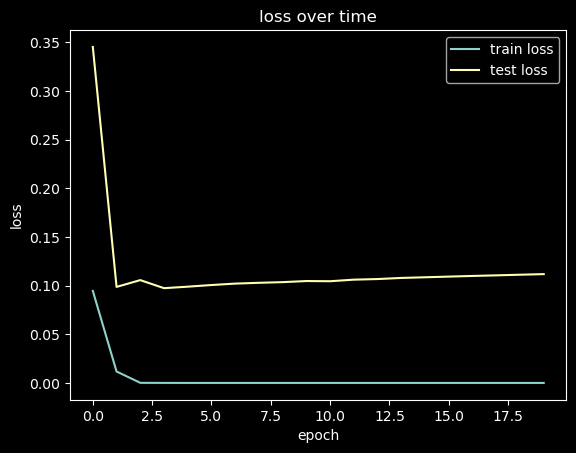

In [87]:
# PLot the loss over time
plt.title("loss over time")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.plot(loss_his, label="train loss")
plt.plot(test_his, label="test loss")
plt.legend()
plt.show()

In [93]:
# Compute the accuracy
def compute_accuracy(model, data_loader):
    n_correct, n_total = 0, 0
    for X, y in data_loader():
        y_hat = model(X)
        preds = (y_hat > 0)
        n_correct += (preds == y).sum().item()
        n_total += y.size(0)
    return n_correct / n_total

In [91]:
train_loader = lambda: data_generator(X_train, y_train, token2int)
test_loader = lambda: data_generator(X_test, y_test, token2int)

In [94]:
print(f"Train acc={compute_accuracy(model, train_loader)}; Test acc={compute_accuracy(model, test_loader)}")

Train acc=1.0; Test acc=0.9874439461883409


Wow! Quite 100% training acc but isn't overfitting. It may mean that   

In [108]:
# Make some prediction
index = 80
x = df_test.iloc[index]['v2']
y = df_test.iloc[index]['v1']
embed_vec = torch.from_numpy(np.array(convert_text(x)).astype(np.float32)).long()
preds = (model(embed_vec.view(-1, embed_vec.size(0))) > 0)
print(f"{x}\nGround truth: {'spam' if y == 1 else 'ham'} \nPred:{'spam' if preds > 0 else 'ham'}")

We have pizza if u want
Ground truth: ham 
Pred:spam
